# Learning Objectives

In this unit you will learn:
1. Limitations of accuracy as a classification metric
2. Importance of understanding the target distribution
3. Strategies for optimizing on Imbalanced Datasets
    1. Class weight
4. Confusion Matrix
5. Beyond accuracy
    1. Recall, Precision and f1-score
6. Threshold Analysis
7. Threshold-independent metrics
    1. ROC and Average Precision

# ML Pipeline

![](media/ml_pipeline_simple.png)

This is what we can expect most of the times from an ML use case in production:

1. A business identifies an opportunity to improve itself by triggering a new process that will be applied in **specific** situations that an ML model is tasked to identify - e.g. triage and referal to a more suited channel that achieves either: 1) greater success, 2) better user satisfaction, 3) more sales. 
   
2. An ML model is trained to identify opportunities to apply
   
3. ???
   
4. Profit

![](media/high_vs_low_risk.jpg)

Actually a step was missing before:

![](media/ml_pipeline_true.png)

![](https://sinyi-chou.github.io/images/classification/classification_threshold.gif)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv(os.path.join('data','unsuspecting_dataset.csv'))
X = df.drop(columns=['Target'])
y = df['Target']

In [3]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

# Train the model

In [4]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

# Model Evaluation

In [5]:
preds = clf.predict(X_val)

## Accuracy

In [6]:
accuracy_score = lambda y_true, preds: sum(preds == y_true) / len(y_true)

In [7]:
accuracy_score(y_val, preds)

0.957375

![](media/big_brain.jpg)

Everything seems ok right? We got 96% accuracy so the problem is solved...

![](media/wrong.jpg)

# Let's dig deeper

Let's say i have a dumb classifier that always predicts 0

In [8]:
dumb_classifier = lambda X: np.array([0] * len(X))

In [9]:
# no need to "train" it. Let's just evaluate it on the validation set
dumb_preds = dumb_classifier(X_val)

accuracy_score(y_val, dumb_preds)

0.955625

Would you look at that, we got a suspiciously high score which is also the same score as with the LogisticRegression. Can you guess what is happening?

In [10]:
# code in class

----

When doing ML development one of the things you should understand well is your target distribution

In [11]:
y.value_counts().to_frame('Value').assign(perc = lambda x: x/x.sum()).round(2)

,Value,perc
Target,,
0,47783,0.96
1,2217,0.04


The positive class is very rare! 

Our model is trying to optimize for the overall error, which is easy to do in imbalanced datasets by always predicting zero

# Confusion Matrix

![](media/confusion.jpg)

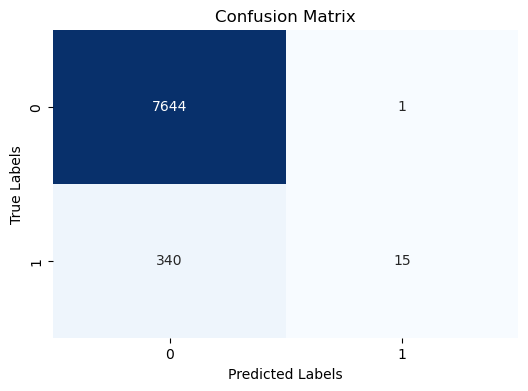

In [12]:
def plot_confusion_matrix(cm):
    # Plotting the confusion matrix
    plt.figure(figsize=(6,4));
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False);  # fmt='g' is for integer formatting
    plt.xlabel('Predicted Labels');
    plt.ylabel('True Labels');
    plt.title('Confusion Matrix');
    plt.show();


cm = confusion_matrix(y_val, preds)

plot_confusion_matrix(cm)

We can look at this data as frequency

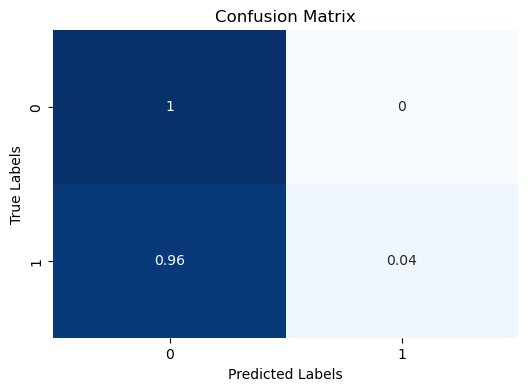

In [13]:
cm_freq = (cm / cm.sum(axis=1)[:, np.newaxis]).round(2)


plot_confusion_matrix(cm_freq)

## How would a random model (coin flip) look like?

In [14]:
# Let's build a random model
np.random.seed(42) # for reproducibility

random_model = lambda X: np.random.randint(0,2,len(X))

random_preds = random_model(X_val)

pd.Series(random_preds).value_counts()

0    4021
1    3979
Name: count, dtype: int64

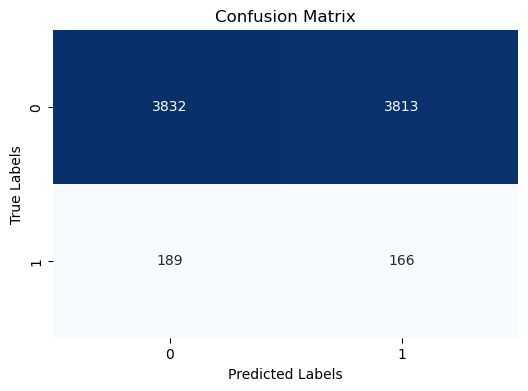

In [15]:
random_cm = confusion_matrix(y_val, random_preds)

plot_confusion_matrix(random_cm)

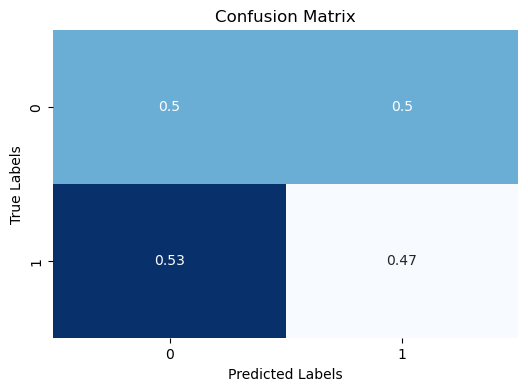

In [16]:
# as frequency
random_cm_freq = (random_cm / random_cm.sum(axis=1)[:, np.newaxis]).round(2)


plot_confusion_matrix(random_cm_freq)

A truly random model will have about 50%/50% distribution on the confusion matrix

# Going beyond accuracy

If you *recall*, our most recent model had the following confusion matrix and accuracy:

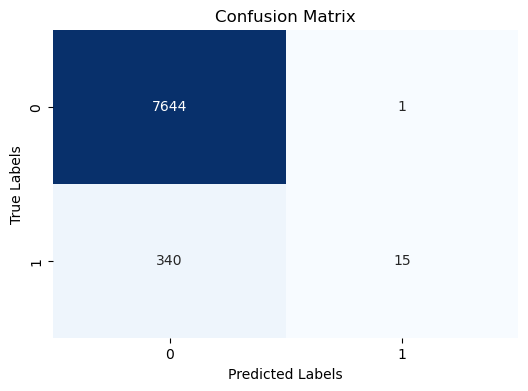

In [17]:
plot_confusion_matrix(cm)

In [18]:
accuracy_score(y_val, preds)

0.957375

accuracy can be a very bad estimator of performance on imbalanced datasets. But more than that, it leaves many questions unanswered

## Recall

> I have 1000 patients and 100 of them have cancer. If my model finds correctly 30 patients with cancer, then it's recall is 30/100 = 30%

<div style="text-align: center;">
    <img src="media/recall.png" alt="Image" width="400" height="auto">
</div>

> Question: How can we trick the recall metric in a similar way we did with accuracy?

In [19]:
# code with students

What recall does our model have?

In [20]:
recall_score = lambda y_true, preds: sum((preds == 1) & (y_true == 1)) / sum(y_true == 1)

recall_score(preds, y_val)

0.9375

our model finds 56% of the positive class. If we were talking about cancer patients, it can find 56% of all cancer patients

----

## Precision

Much like yin and yang, precision complements recall extremely well

> Everytime you predict positive, how many times are you actually right?

I have 1000 patients where 100 have cancer. I predict 200 of them to have cancer. I was right on 50 of them, but for the remaining 150 I wasn't (i.e. False positives). My precision is thus: 50/200 = 0.25

<div style="text-align: center;">
    <img src="media/precision.png" alt="Image" width="400" height="auto">
</div>


What precision does our model have?

In [21]:
precision_score = lambda y_true, preds : sum((preds == 1) & (y_true == 1)) / sum(preds == 1)

precision_score(y_val, preds)

0.9375

5% only! So everytime the model predicts a positive class, it is correct only 5% of the time

> How can one optimize for precision?

In [22]:
# answer with students

## Threshold Analysis

In [23]:
probas = clf.predict_proba(X_val)[:,1]
probas[:5] # show only the first 5

array([0.1567092 , 0.02211078, 0.04618332, 0.13118285, 0.09686085])

if you remember classifier models output probabilities. And we obtain predictions by passsing these probabilities through a threshold that, by default, is 0.5. So anything above 0.5 probability we classify as class 1, and the remaining as class 0.

![](media/threshold.jpg)

Let's try a bunch of thresholds

In [24]:
ths = np.arange(0.1,1,step=0.05)
ths

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [25]:
results = []
for decision_threshold in ths:
    th_preds = (probas > decision_threshold).astype(int)

    recall = recall_score(y_val, th_preds)
    precision = precision_score(y_val, th_preds)
    
    results.append({"decision_threshold":decision_threshold,"recall":recall,"precision":precision})

results = pd.DataFrame(results).set_index('decision_threshold')
results

/var/folders/bp/hxsq_5h96wv5hnzrf6mldthm0000gp/T/ipykernel_78514/3570342190.py:1: RuntimeWarning: invalid value encountered in scalar divide
  precision_score = lambda y_true, preds : sum((preds == 1) & (y_true == 1)) / sum(preds == 1)


,recall,precision
decision_threshold,,
0.10,0.436620,0.210027
0.15,0.318310,0.347692
0.20,0.239437,0.497076
0.25,0.185915,0.600000
0.30,0.143662,0.680000
0.35,0.092958,0.767442
0.40,0.064789,0.821429
0.45,0.050704,0.857143
0.50,0.042254,0.937500


<Axes: xlabel='decision_threshold'>

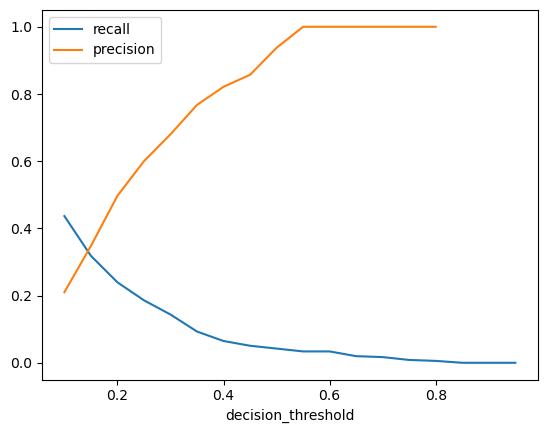

In [26]:
results.plot()

In our example, because our model isn't very good, we didn't see a drastic improvement in precision (although it doubles from 0.5 threshold to 0.8), but if you take a look at recall, it increases by 30% (percentual points) just from lowering the decision threshold from 0.5 to 0.4!

### Rules of thumb

**Consequences of choosing a high decision threshold**

If you only make a prediction when the model is absolutely certain:
- **Your precision will be higher** because you are only classifying as positive when you are certain (i.e. you are decreasing your FP)
- **Your recall will be lower** because you are missing out on a lot of positives (i.e. you are increasing your FN: False Negatives)
> you decrease your FPs (good) at the cost of increasing False Negatives (bad)

**Consequences of having a low decision threshold**

If you make positive predictions with a relatively low decision threshold:
- **Your recall will be higher**. Since you are classifying more things as positive, you are more likely to find more Positives than you were before (you are increasing your TP: True Positives)
- **Your precision will be lower** because you are increasing your Positives indiscriminately and in an imbalanced dataset, you are more likely to include False Positives doing that than True Positives (i.e. you are increasing your FP).
> you increase your TPs (good) at the cost of FP (bad)



## F1 - score

In the end what should you optimize for? If we go full precision-mode we are sacrificing recall and if we go full-recall model we sacrifice precision.

This is where F1 score comes in handy - when we don't have a particular balance to optimize

![](media/F1-Score.png)

Ignore the complex formula, this is what's called an [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean). It is very similar to a simple mean/average between two numbers, except the lower number will push the average a bit more towards itself than you would expect.

Why is this useful? Usually in ML systems we want a good tradeoff between recall and precision. We are not really interested in extremes where the precision is super good and the recall is super bad. For these cases it is generally preferable to have a good balance between the two. Let's look at an example:


Take $H(r,p)$ to be the harmonic mean between a recall and precision scores, and $M(r,p)$ to be a normal mean between the two scores.

Scenario 1:

r = 1.0, p = 0.0
- $H(r,p) = 0$
- $M(r,p) = 0.5$

Scenario 2:

r = 0.9, p = 0.3

- $H(r,p) = 0.45$
- $M(r,p) = 0.60$

Scenario 3:

r = 0.7
p = 0.9

- $H(r,p) = 0.79$
- $M(r,p) = 0.80$


In [27]:
f1_score = lambda y_true, y_pred: 2 * precision_score(y_true, y_pred) * recall_score(y_true, y_pred) / (precision_score(y_true, y_pred) + recall_score(y_true, y_pred))


f1_score(y_val, preds)

0.08086253369272238

# Threshold Independent metrics

> A model is good depending on how well it can order the negatives and positives well along its probability outputs

![](media/classification_threshold.gif)

A perfect model would place all red circles on the left side and all blue ones on the right side. But in reality we always get something messy like the image above:

Now it would be nice to summarize a model's performance without having to decide on a threshold, and thankfully we have 2 measures for that!

## ROC (Receiver Operating Characteristic)

At each intersection record the:
-  **True Positive Rate** (recall) and
- **False Positive Rate** (probability of false positive/alarm).

<img src="media/roc-1.webp"  width="600">

A random model would have always the characteristic of the dashed blue line above. And a perfect model is one where its ROC curve is highest:

<img src="media/Roc_curve.svg.png"  width="500">

We can summarize a ROC performance by taking it's **Area Under the Curve (AUC)**

A random model will have an AUC-ROC of 0.5, and a perfect model has AUC-ROC of 1.0

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve

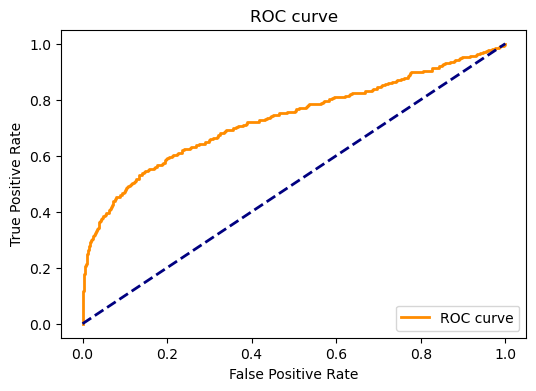

In [29]:
fpr, tpr, thresholds = roc_curve(y_val, probas)

# plot the curve
plt.figure(figsize=(6,4));
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve');
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--'); # random model
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC curve');
plt.legend(loc="lower right");
plt.show();

In [30]:
roc_auc_score(y_val, probas)

0.7325041682403117

So we have a model slightly better than random

## Precision-recall Curve and Average Precision

Plotting the precision-recall curve is another way to evaluate models without using a threshold.

We still compute the checkpoints at each intersection but instead of recording the FPR and the TPR, we record the Precision and the Recall (TPR)

<img src="media/Precision-Recall-Curve-of-a-Logistic-Regression-Model-and-a-No-Skill-Classifier2.webp"  width="700">


A random model is one that has a curve with a value equal to the prevalence of the data (% of positives).

The area under the curve is called the **average-precision**

In [31]:
from sklearn.metrics import average_precision_score, precision_recall_curve

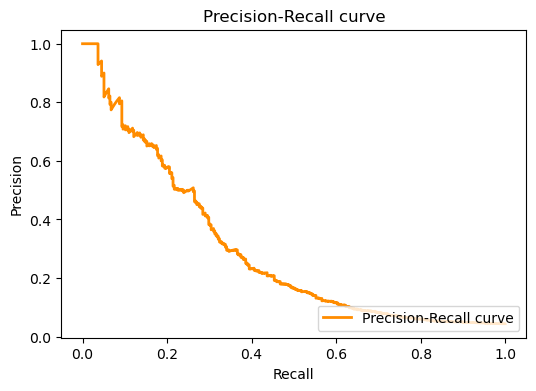

In [32]:
precisions, recalls, thresholds = precision_recall_curve(y_val, probas)

# plot the curve
plt.figure(figsize=(6,4));
plt.plot(recalls, precisions, color='darkorange', lw=2, label='Precision-Recall curve');
#plt.plot([0, 1], [y_val.mean(), y_val.mean()], color='navy', lw=2, linestyle='--'); # random model
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision-Recall curve');
plt.legend(loc="lower right");
plt.show();

In [33]:
average_precision_score(y_val, probas)

0.2947338825889003

## When to use either one?

Either one allows you to compare models to understand which model is better.

In a balanced dataset, using AUC-ROC is fine. But in imbalanced datasets you should use the Average Precision.

In a very imbalanced dataset, you have a lot of Negatives. In ROC, if you try to increase recall by lowering the threshold, you increase the FPR. However the FPR won't increase by much because the number of negatives is high (take a look at the denominator of the formula).

Average Precision is much more unforgiving, because if you lower the threshold to increase recall, your precision metric will be easily affected as a result for each False Positive you introduce.

bonus: average precision suffers from a similar "downfall" as AUC-ROC, but when the positive class is very prevalent and the negative is quite rare. But usually in ML the rarer class is what we consider the positive class.

# Additional references

[A really cool article on area under the curve](https://sinyi-chou.github.io/classification-auc/)